In [27]:
import pandas as pd
import numpy as np
import openml
from sklearn.linear_model import LinearRegression 
import lightgbm as lgbm
import optuna
from scipy.spatial.distance import mahalanobis
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from engression import engression, engression_bagged
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
#openml.config.apikey = 'FILL_IN_OPENML_API_KEY'  # set the OpenML Api Key
SUITE_ID = 336 # Regression on numerical features
#SUITE_ID = 337 # Classification on numerical features
#SUITE_ID = 335 # Regression on numerical and categorical features
#SUITE_ID = 334 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

task = openml.tasks.get_task(361072)  # download the OpenML task
dataset = task.get_dataset()

X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute)

c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
c:\Users\dalma\AppData\Local\Programs\Python\Python310\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [37]:
x_pca = X.loc[:, ].values
x_pca = StandardScaler().fit_transform(x_pca) # normalizing the features
pca = PCA(n_components=2)
principalComponents = pd.DataFrame(pca.fit_transform(x_pca), index=X.index)

In [38]:
# calculate the mean and covariance matrix of the dataset
mean = np.mean(principalComponents, axis=0)
cov = np.cov(principalComponents.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in principalComponents.values]

mahalanobis_dist=pd.Series(mahalanobis_dist,index=principalComponents.index)
far_index=mahalanobis_dist.index[np.where(mahalanobis_dist>=np.quantile(mahalanobis_dist,0.8))[0]]
close_index=mahalanobis_dist.index[np.where(mahalanobis_dist<np.quantile(mahalanobis_dist,0.8))[0]]

X_train = X.loc[close_index,:]
X_test = X.loc[far_index,:]
y_train = y.loc[close_index]
y_test = y.loc[far_index]


x_pca_train = X_train.loc[:, ].values
x_pca_train = StandardScaler().fit_transform(x_pca_train) # normalizing the features
pca_train = PCA(n_components=2)
principalComponents_train = pd.DataFrame(pca.fit_transform(x_pca_train), index=X_train.index)

mean = np.mean(principalComponents_train, axis=0)
cov = np.cov(principalComponents_train.T)

# calculate the Mahalanobis distance for each data point
mahalanobis_dist_ = [mahalanobis(x, mean, np.linalg.inv(cov)) for x in principalComponents_train.values]

mahalanobis_dist_=pd.Series(mahalanobis_dist_,index=principalComponents_train.index)
far_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_>=np.quantile(mahalanobis_dist_,0.8))[0]]
close_index_=mahalanobis_dist_.index[np.where(mahalanobis_dist_<np.quantile(mahalanobis_dist_,0.8))[0]]

X_train_ = X_train.loc[close_index_,:]
X_val = X_train.loc[far_index_,:]
y_train_ = y_train.loc[close_index_]
y_val = y_train.loc[far_index_]

In [12]:
N_TRIALS=5

def gp(trial):

    params = {'lenghtscale': trial.suggest_float('lenghtscale', 0, 10)}
    
    gp=GaussianProcessRegressor(kernel=Matern(length_scale=params['lenghtscale'], nu=1.5))
    gp.fit(X_train_, y_train_)
    y_val_hat_gp=gp.predict(X_val)
    RMSE_gp=np.sqrt(np.mean((y_val-y_val_hat_gp)**2))
    return RMSE_gp

sampler_gp = optuna.samplers.TPESampler(seed=10)
study_gp = optuna.create_study(sampler=sampler_gp, direction='minimize')
study_gp.optimize(gp, n_trials=N_TRIALS)

gp_model=GaussianProcessRegressor(kernel=Matern(length_scale=study_gp.best_params['lenghtscale'], nu=1.5))


def boosted(trial):

    params = {'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
              'n_estimators': trial.suggest_int('n_estimators', 100, 500),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              #'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)}
    
    boosted_tree_model=lgbm.LGBMRegressor(**params)
    boosted_tree_model.fit(X_train_, y_train_)
    y_val_hat_boost=boosted_tree_model.predict(X_val)
    RMSE_boost=np.sqrt(np.mean((y_val-y_val_hat_boost)**2))

    return RMSE_boost

sampler_boost = optuna.samplers.TPESampler(seed=10)
study_boost = optuna.create_study(sampler=sampler_boost, direction='minimize')
study_boost.optimize(boosted, n_trials=N_TRIALS)

boosted_model=lgbm.LGBMRegressor(**study_boost.best_params)


def rf(trial):

    params = {'boosting_type':"rf",
              'n_estimators': trial.suggest_int('n_estimators', 100, 500),
              'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
              'subsample': trial.suggest_float('subsample', 0.5, 1),
              'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0, 1),
              #'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)}
    
    rf_model=lgbm.LGBMRegressor(**params)
    rf_model.fit(X_train_, y_train_)
    y_val_hat_rf=rf_model.predict(X_val)
    RMSE_rf=np.sqrt(np.mean((y_val-y_val_hat_rf)**2))

    return RMSE_rf

sampler_rf = optuna.samplers.TPESampler(seed=10)
study_rf = optuna.create_study(sampler=sampler_rf, direction='minimize')
study_rf.optimize(rf, n_trials=N_TRIALS)

rf_model=lgbm.LGBMRegressor(**study_rf.best_params)

def engressor_NN(trial):

    params = {'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
              'num_epoches': trial.suggest_int('num_epoches', 100, 1000),
              'num_layer': trial.suggest_int('num_layer', 2, 5),
              'hidden_dim': trial.suggest_int('hidden_dim', 50, 100),
              'noise_dim': trial.suggest_int('noise_dim', 50, 100),}
    
    engressor_model=engression(torch.Tensor(np.array(X_train_)), torch.Tensor(np.array(y_train_).reshape(-1,1)), lr=params['learning_rate'], num_epoches=params['num_epoches'],num_layer=params['num_layer'], hidden_dim=params['hidden_dim'], noise_dim=params['noise_dim'], batch_size=1000)
    y_val_hat_engression=engressor_model.predict(torch.Tensor(np.array(X_val)), target="mean")
    RMSE_engression=np.sqrt((((torch.Tensor(np.array(y_val).reshape(-1,1)))-y_val_hat_engression)**2).mean(axis=0))

    return RMSE_engression

sampler_engression = optuna.samplers.TPESampler(seed=10)
study_engression = optuna.create_study(sampler=sampler_engression, direction='minimize')
study_engression.optimize(engressor_NN, n_trials=N_TRIALS)

[I 2023-12-04 17:22:37,917] A new study created in memory with name: no-name-eba23015-e1e8-4552-94b6-f26d2dd6f065
[I 2023-12-04 17:22:50,487] Trial 0 finished with value: 81.02654686409919 and parameters: {'lenghtscale': 7.71320643266746}. Best is trial 0 with value: 81.02654686409919.
[I 2023-12-04 17:23:01,021] Trial 1 finished with value: 81.02654686409919 and parameters: {'lenghtscale': 0.207519493594015}. Best is trial 0 with value: 81.02654686409919.
[I 2023-12-04 17:23:10,895] Trial 2 finished with value: 81.02654686409919 and parameters: {'lenghtscale': 6.336482349262754}. Best is trial 0 with value: 81.02654686409919.
[I 2023-12-04 17:23:20,405] Trial 3 finished with value: 81.02654686409919 and parameters: {'lenghtscale': 7.488038825386118}. Best is trial 0 with value: 81.02654686409919.
[I 2023-12-04 17:23:30,475] Trial 4 finished with value: 81.02654686409919 and parameters: {'lenghtscale': 4.9850701230259045}. Best is trial 0 with value: 81.02654686409919.
[I 2023-12-04 17

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-12-04 17:23:31,625] Trial 1 finished with value: 4.4895336569115845 and parameters: {'learning_rate': 0.11317352611989298, 'n_estimators': 179, 'reg_lambda': 0.0699481785242808, 'max_depth': 6, 'min_child_samples': 18}. Best is trial 1 with value: 4.4895336569115845.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2023-12-04 17:23:32,143] Trial 2 finished with value: 7.153818721600584 and parameters: {'learning_rate': 0.3429945493655308, 'n_estimators': 482, 'reg_lambda': 1.08526150100961e-08, 'max_depth': 16, 'min_child_samples': 83}. Best is trial 1 with value: 4.4895336569115845.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458


[I 2023-12-04 17:23:32,611] Trial 3 finished with value: 6.433117721979714 and parameters: {'learning_rate': 0.3066505073478647, 'n_estimators': 389, 'reg_lambda': 4.235304245072407e-06, 'max_depth': 28, 'min_child_samples': 75}. Best is trial 1 with value: 4.4895336569115845.
[I 2023-12-04 17:23:32,788] Trial 4 finished with value: 5.086187263278451 and parameters: {'learning_rate': 0.27172963963761937, 'n_estimators': 157, 'reg_lambda': 2.2912202578440842e-05, 'max_depth': 21, 'min_child_samples': 50}. Best is trial 1 with value: 4.4895336569115845.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-12-04 17:23:32,795] A new study created in memory with name: no-name-704bbe68-8807-4c1e-8469-d958b28cbc78


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458


[I 2023-12-04 17:23:33,445] Trial 0 finished with value: 5.29583724074511 and parameters: {'n_estimators': 409, 'reg_lambda': 1.537331564587801e-08, 'max_depth': 20, 'subsample_freq': 8, 'subsample': 0.7492535061512953, 'feature_fraction_bynode': 0.22479664553084766, 'min_child_samples': 28}. Best is trial 0 with value: 5.29583724074511.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2023-12-04 17:23:33,653] Trial 1 finished with value: 14.779020260424385 and parameters: {'n_estimators': 404, 'reg_lambda': 3.32657660618516e-07, 'max_depth': 3, 'subsample_freq': 7, 'subsample': 0.9766966730974682, 'feature_fraction_bynode': 0.003948266327914451, 'min_child_samples': 56}. Best is trial 0 with value: 5.29583724074511.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458


[I 2023-12-04 17:23:34,316] Trial 2 finished with value: 5.4278000417253125 and parameters: {'n_estimators': 425, 'reg_lambda': 0.003256376421394008, 'max_depth': 22, 'subsample_freq': 3, 'subsample': 0.9588870612564717, 'feature_fraction_bynode': 0.7145757833976906, 'min_child_samples': 59}. Best is trial 0 with value: 5.29583724074511.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458


[I 2023-12-04 17:23:34,556] Trial 3 finished with value: 5.334631979535034 and parameters: {'n_estimators': 157, 'reg_lambda': 2.2912202578440842e-05, 'max_depth': 21, 'subsample_freq': 5, 'subsample': 0.7170069966666468, 'feature_fraction_bynode': 0.6177669784693172, 'min_child_samples': 56}. Best is trial 0 with value: 5.29583724074511.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 5242, number of used features: 21
[LightGBM] [Info] Start training from score 89.019458


[I 2023-12-04 17:23:35,211] Trial 4 finished with value: 5.108258741428461 and parameters: {'n_estimators': 360, 'reg_lambda': 0.0025665550309028774, 'max_depth': 25, 'subsample_freq': 6, 'subsample': 0.9543244404043341, 'feature_fraction_bynode': 0.3192360889885453, 'min_child_samples': 18}. Best is trial 4 with value: 5.108258741428461.
[I 2023-12-04 17:23:35,216] A new study created in memory with name: no-name-cabf616a-8844-4322-8fce-0d00a6e0d9cf


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 6] energy-loss: 0.4924,  E(|Y-Yhat|): 0.5708,  E(|Yhat-Yhat'|): 0.1568
[Epoch 100 (84%), batch 6] energy-loss: 0.1658,  E(|Y-Yhat|): 0.2638,  E(|Yhat-Yhat'|): 0.1960

Training loss on the original (non-standardized) scale:
	Energy-loss: 19.6814,  E(|Y-Yhat|): 22.1636,  E(|Yhat-Yhat'|): 4.9645

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 


[I 2023-12-04 17:23:52,236] Trial 0 finished with value: 23.918275833129883 and parameters: {'learning_rate': 0.38588900099010626, 'num_epoches': 118, 'num_layer': 4, 'hidden_dim': 88, 'noise_dim': 75}. Best is trial 0 with value: 23.918275833129883.


Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 6] energy-loss: 0.4374,  E(|Y-Yhat|): 0.6997,  E(|Yhat-Yhat'|): 0.5245
[Epoch 100 (36%), batch 6] energy-loss: 0.0976,  E(|Y-Yhat|): 0.1850,  E(|Yhat-Yhat'|): 0.1749
[Epoch 200 (72%), batch 6] energy-loss: 0.0889,  E(|Y-Yhat|): 0.1854,  E(|Yhat-Yhat'|): 0.1928

Training loss on the original (non-standardized) scale:
	Energy-loss: 2.8811,  E(|Y-Yhat|): 3.5971,  E(|Yhat-Yhat'|): 1.4320

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 


[I 2023-12-04 17:24:27,908] Trial 1 finished with value: 8.68303108215332 and parameters: {'learning_rate': 0.11317352611989298, 'num_epoches': 278, 'num_layer': 5, 'hidden_dim': 58, 'noise_dim': 54}. Best is trial 1 with value: 8.68303108215332.


Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 6] energy-loss: 0.4480,  E(|Y-Yhat|): 0.6581,  E(|Yhat-Yhat'|): 0.4202
[Epoch 100 (10%), batch 6] energy-loss: 0.1019,  E(|Y-Yhat|): 0.2085,  E(|Yhat-Yhat'|): 0.2132
[Epoch 200 (21%), batch 6] energy-loss: 0.0914,  E(|Y-Yhat|): 0.2149,  E(|Yhat-Yhat'|): 0.2469
[Epoch 300 (31%), batch 6] energy-loss: 0.0853,  E(|Y-Yhat|): 0.1788,  E(|Yhat-Yhat'|): 0.1870
[Epoch 400 (42%), batch 6] energy-loss: 0.0881,  E(|Y-Yhat|): 0.1861,  E(|Yhat-Yhat'|): 0.1959
[Epoch 500 (52%), batch 6] energy-loss: 0.0897,  E(|Y-Yhat|): 0.1980,  E(|Yhat-Yhat'|): 0.2167
[Epoch 600 (62%), batch 6] energy-loss: 0.0893,  E(|Y-Yhat|): 0.1686,  E(|Yhat-Yhat'|): 0.1586
[Epoch 700 (73%), batch 6] energy-loss: 0.

[I 2023-12-04 17:25:41,417] Trial 2 finished with value: 3.4968483448028564 and parameters: {'learning_rate': 0.3429945493655308, 'num_epoches': 959, 'num_layer': 2, 'hidden_dim': 76, 'noise_dim': 91}. Best is trial 2 with value: 3.4968483448028564.



Training loss on the original (non-standardized) scale:
	Energy-loss: 1.3831,  E(|Y-Yhat|): 2.8913,  E(|Yhat-Yhat'|): 3.0164

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 6] energy-loss: 0.5737,  E(|Y-Yhat|): 0.8260,  E(|Yhat-Yhat'|): 0.5045
[Epoch 100 (13%), batch 6] energy-loss: 0.0969,  E(|Y-Yhat|): 0.1926,  E(|Yhat-Yhat'|): 0.1914
[Epoch 200 (27%), batch 6] energy-loss: 0.0970,  E(|Y-Yhat|): 0.1698,  E(|Yhat-Yhat'|): 0.1456
[Epoch 300 (40%), batch 6] energy-loss: 0.1146,  E(|Y-Yhat|): 0.2215,  E(|Yhat-Yhat'|): 0.2138
[Epoch 400 (53%)

[I 2023-12-04 17:27:06,152] Trial 3 finished with value: 4.880773067474365 and parameters: {'learning_rate': 0.3066505073478647, 'num_epoches': 750, 'num_layer': 3, 'hidden_dim': 96, 'noise_dim': 86}. Best is trial 2 with value: 3.4968483448028564.


Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 6] energy-loss: 0.5765,  E(|Y-Yhat|): 0.9747,  E(|Yhat-Yhat'|): 0.7966
[Epoch 100 (43%), batch 6] energy-loss: 0.0705,  E(|Y-Yhat|): 0.1762,  E(|Yhat-Yhat'|): 0.2115
[Epoch 200 (87%), batch 6] energy-loss: 0.0705,  E(|Y-Yhat|): 0.1603,  E(|Yhat-Yhat'|): 0.1796

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.2250,  E(|Y-Yhat|): 2.6920,  E(|Yhat-Yhat'|): 2.9340

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 


[I 2023-12-04 17:27:29,279] Trial 4 finished with value: 3.761934280395508 and parameters: {'learning_rate': 0.27172963963761937, 'num_epoches': 228, 'num_layer': 3, 'hidden_dim': 84, 'noise_dim': 72}. Best is trial 2 with value: 3.4968483448028564.


In [13]:
gp_model.fit(X_train, y_train)
y_test_hat_gp=gp_model.predict(X_test)
RMSE_gp=np.sqrt(np.mean((y_test-y_test_hat_gp)**2))

boosted_model.fit(X_train, y_train)
y_test_hat_boosted=boosted_model.predict(X_test)
RMSE_boosted=np.sqrt(np.mean((y_test-y_test_hat_boosted)**2))

rf_model.fit(X_train, y_train)
y_test_hat_rf=rf_model.predict(X_test)
RMSE_rf=np.sqrt(np.mean((y_test-y_test_hat_rf)**2))

lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_hat_linreg=lin_reg.predict(X_test)
RMSE_linreg=np.sqrt(np.mean((y_test-y_test_hat_linreg)**2))

params=study_engression.best_params
engressor_model=engression(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train).reshape(-1,1)), lr=params['learning_rate'], num_epoches=params['num_epoches'],num_layer=params['num_layer'], hidden_dim=params['hidden_dim'], noise_dim=params['noise_dim'], batch_size=1000)
y_test_hat_engression=engressor_model.predict(torch.Tensor(np.array(X_test)), target="mean")
RMSE_engression=np.sqrt((((torch.Tensor(np.array(y_test).reshape(-1,1)))-y_test_hat_engression)**2).mean(axis=0))

print("RMSE linear regression: ",RMSE_linreg)
print("RMSE boosted trees", RMSE_boosted)
print("RMSE random forest", RMSE_rf)
print("RMSE gaussian process", RMSE_gp)
print("RMSE engression", RMSE_engression)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4361
[LightGBM] [Info] Number of data points in the train set: 6553, number of used features: 21
[LightGBM] [Info] Start training from score 86.920800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [15]:
print("RMSE linear regression: ",RMSE_linreg)
print("RMSE boosted trees", RMSE_boosted)
print("RMSE random forest", RMSE_rf)
print("RMSE gaussian process", RMSE_gp)
print("RMSE engression", RMSE_engression)

RMSE linear regression:  11.311940814238275
RMSE boosted trees 6.488074133097913
RMSE random forest 6.433290092558198
RMSE gaussian process 74.5171031221566
RMSE engression tensor([12.7747])


In [39]:
principalComponents_test = principalComponents.loc[far_index,:]

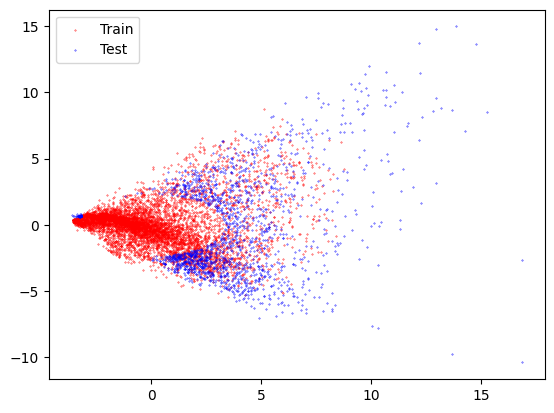

In [43]:
import matplotlib.pyplot as plt
plt.scatter(principalComponents_train.loc[:,0],principalComponents_train.loc[:,1],c='r',s=0.1)
plt.scatter(principalComponents_test.loc[:,0],principalComponents_test.loc[:,1],c='b',s=0.1)
plt.legend(["Train","Test"])
plt.show()